In [1]:
import pandas as pd
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial import distance_matrix

In [2]:
# Define the file path to your sampled dataset
file_path = 'sampled_dataset.csv'  # Update this path if your file is saved in a different location

# Load the dataset
sampled_data = pd.read_csv(file_path)

# Display basic information about the dataset to ensure it's loaded correctly
print(sampled_data.info())

# Display the first few rows of the dataset
print(sampled_data.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12004 entries, 0 to 12003
Data columns (total 19 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   index       12004 non-null  int64  
 1   X           12004 non-null  float64
 2   Y           12004 non-null  float64
 3   FID         12004 non-null  int64  
 4   FEATURE_ID  12004 non-null  int64  
 5   NAME        12004 non-null  object 
 6   ADDRESS     12004 non-null  object 
 7   ADDRESS2    12004 non-null  object 
 8   ADDRESS3    12004 non-null  object 
 9   CITY        12004 non-null  object 
 10  STATE       12004 non-null  object 
 11  ZIP         12004 non-null  int64  
 12  PHONE       12004 non-null  object 
 13  LATITUDE    12004 non-null  float64
 14  LONGITUDE   12004 non-null  float64
 15  MATCHSTATU  12004 non-null  object 
 16  PLACEMENT   12004 non-null  object 
 17  CENSUSCODE  12004 non-null  object 
 18  BUSINESSNA  12004 non-null  object 
dtypes: float64(4), int64(4), 

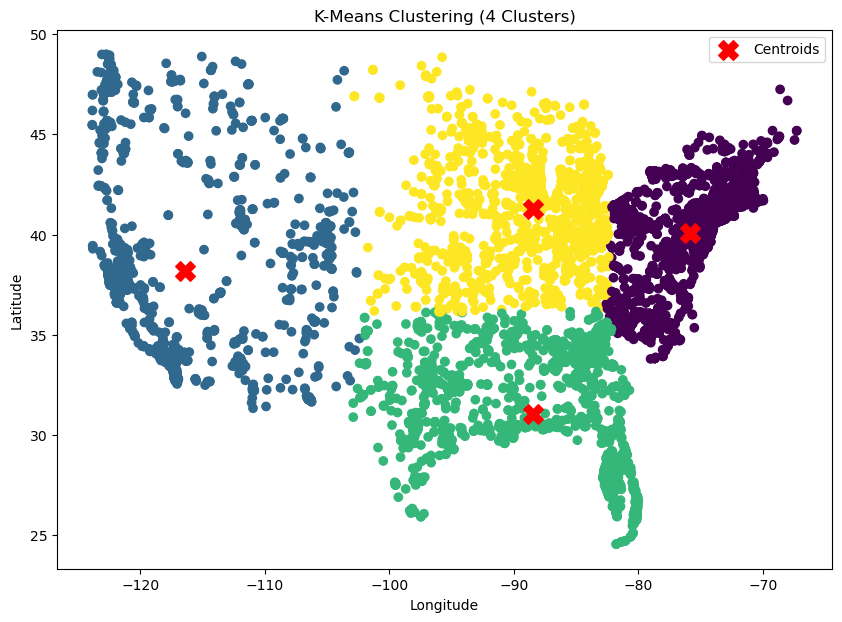

Number of points in each cluster:
Cluster
0    3805
3    2993
2    2907
1    2299
Name: count, dtype: int64


In [3]:
# Select the features for clustering (latitude and longitude)
X = sampled_data[['LATITUDE', 'LONGITUDE']]

# Apply K-Means clustering with 4 clusters
kmeans = KMeans(n_clusters=4, random_state=42)
sampled_data['Cluster'] = kmeans.fit_predict(X)

# Centroids of the clusters
centroids = kmeans.cluster_centers_

# Visualize the clusters
plt.figure(figsize=(10, 7))
plt.scatter(sampled_data['LONGITUDE'], sampled_data['LATITUDE'], c=sampled_data['Cluster'], cmap='viridis', marker='o')
plt.scatter(centroids[:, 1], centroids[:, 0], c='red', marker='X', s=200, label='Centroids')
plt.title('K-Means Clustering (4 Clusters)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()
plt.show()

# Display the number of points in each cluster
cluster_counts = sampled_data['Cluster'].value_counts()
print("Number of points in each cluster:")
print(cluster_counts)

In [4]:
import numpy as np
import random
from scipy.spatial import distance_matrix

# Function to calculate the total distance of a route
def calculate_total_distance(route, dist_matrix):
    total_distance = 0
    for i in range(len(route) - 1):
        total_distance += dist_matrix[route[i], route[i + 1]]
    return total_distance

# Function to create an initial population with fixed start and end points
def create_population_fixed_start_end(num_individuals, num_locations, start_point, end_point):
    population = []
    for _ in range(num_individuals):
        middle = random.sample(range(1, num_locations - 1), num_locations - 2)
        population.append([start_point] + middle + [end_point])
    return population

# Function to evaluate fitness of each individual
def evaluate_population(population, dist_matrix):
    fitness = []
    for individual in population:
        distance = calculate_total_distance(individual, dist_matrix)
        fitness.append(1 / distance)  # Fitness is the inverse of distance (minimization problem)
    return fitness

def crossover_fixed_start_end(parent1, parent2):
    start_point = parent1[0]
    end_point = parent1[-1]
    
    size = len(parent1)
    start, end = sorted(random.sample(range(1, size - 1), 2))
    
    child1 = [None] * size
    child2 = [None] * size
    
    # Copy the crossover segment from each parent to the corresponding child
    child1[start:end] = parent1[start:end]
    child2[start:end] = parent2[start:end]
    
    # Fill the remaining slots with the other parent's genes in the order they appear
    def fill_remaining_slots(child, parent):
        child_idx = 1  # Start filling after the fixed start point
        for gene in parent[1:-1]:  # Skip the start and end points
            if gene not in child:
                while child[child_idx] is not None:
                    child_idx += 1
                child[child_idx] = gene
        return child
    
    child1 = fill_remaining_slots(child1, parent2)
    child2 = fill_remaining_slots(child2, parent1)
    
    # Ensure the fixed start and end points are preserved
    child1[0], child1[-1] = start_point, end_point
    child2[0], child2[-1] = start_point, end_point
    
    return child1, child2

# Function to mutate an individual while keeping start and end points fixed
def mutate_fixed_start_end(individual, mutation_rate):
    if random.random() < mutation_rate:
        i, j = random.sample(range(1, len(individual) - 1), 2)
        individual[i], individual[j] = individual[j], individual[i]
    return individual

# Function to select parents based on fitness (Roulette Wheel Selection)
def select_parents(population, fitness):
    fitness_sum = sum(fitness)
    selection_probs = [f / fitness_sum for f in fitness]
    
    parent1 = population[np.random.choice(len(population), p=selection_probs)]
    parent2 = population[np.random.choice(len(population), p=selection_probs)]
    
    return parent1, parent2

# Function to run the genetic algorithm with fixed start and end points
def genetic_algorithm_fixed_start_end(dist_matrix, start_point, end_point, num_generations=100, population_size=50, mutation_rate=0.01):
    num_locations = dist_matrix.shape[0]
    population = create_population_fixed_start_end(population_size, num_locations, start_point, end_point)
    best_route = None
    best_distance = float('inf')
    
    for generation in range(num_generations):
        fitness = evaluate_population(population, dist_matrix)
        new_population = []
        
        for _ in range(population_size // 2):  # Half the population size because we generate 2 children per loop
            parent1, parent2 = select_parents(population, fitness)
            child1, child2 = crossover_fixed_start_end(parent1, parent2)
            child1 = mutate_fixed_start_end(child1, mutation_rate)
            child2 = mutate_fixed_start_end(child2, mutation_rate)
            new_population.extend([child1, child2])
        
        population = new_population
        
        # Check if there is a new best route
        best_fitness_index = np.argmax(fitness)
        best_individual = population[best_fitness_index]
        best_individual_distance = calculate_total_distance(best_individual, dist_matrix)
        
        if best_individual_distance < best_distance:
            best_distance = best_individual_distance
            best_route = best_individual
    
    return best_route, best_distance

# Example: Apply GA on one of the clusters with fixed start and end points
for cluster_id in sampled_data['Cluster'].unique():
    cluster_data = sampled_data[sampled_data['Cluster'] == cluster_id]
    
    # Identify the warehouse and drop boxes within the cluster
    warehouse_index = cluster_data[cluster_data['NAME'] == 'Authorized Shipping Outlet'].index[0]
    drop_box_index = cluster_data[cluster_data['NAME'] == 'UPS Drop Box'].index[0]
    
    # Combine warehouse and drop boxes for the distance matrix calculation
    locations = cluster_data[['LATITUDE', 'LONGITUDE']].values
    dist_matrix = distance_matrix(locations, locations)
    
    # Apply GA on this cluster's data
    best_route, best_distance = genetic_algorithm_fixed_start_end(
        dist_matrix, start_point=warehouse_index, end_point=drop_box_index, 
        num_generations=100, population_size=50, mutation_rate=0.01
    )
    
    print(f"Cluster {cluster_id}: Shortest path distance using GA: {best_distance:.2f} km")
    print("Best route order of locations:", best_route)

Cluster 0: Shortest path distance using GA: 16874.58 km
Best route order of locations: [15, 3579, 2398, 1218, 1754, 2811, 2244, 2013, 3511, 2521, 1729, 712, 1536, 985, 2582, 3628, 1787, 1291, 3004, 1031, 2330, 3336, 2899, 1550, 3149, 1368, 1398, 1186, 872, 2693, 413, 1203, 556, 2376, 918, 863, 802, 2365, 3529, 2488, 2436, 2518, 1556, 647, 292, 1571, 3164, 1775, 2213, 1882, 3430, 1753, 1839, 636, 1001, 2551, 2722, 3474, 1653, 3595, 2930, 943, 1140, 1271, 3208, 1602, 672, 2583, 782, 3674, 17, 1502, 417, 2164, 72, 1016, 2660, 311, 2499, 2423, 3768, 2764, 265, 68, 3450, 2211, 2699, 504, 419, 2706, 2359, 3192, 2645, 1057, 553, 1767, 803, 1015, 2327, 1255, 3364, 32, 1850, 519, 1246, 3128, 3145, 2915, 831, 840, 2437, 1539, 1237, 1183, 763, 2251, 3283, 2319, 3254, 2197, 1144, 2318, 3027, 1327, 3574, 1448, 990, 3563, 1986, 2503, 2504, 948, 3111, 3417, 1557, 2854, 1429, 542, 1724, 3320, 2549, 1248, 1319, 2619, 2341, 1512, 450, 456, 3329, 253, 3152, 3186, 3091, 3498, 20, 1893, 245, 994, 626, 3251

In [5]:
# Define constants
fuel_consumption_per_km = 0.12  # in liters per km
co2_emissions_factor = 2.31  # kg CO2 per liter of petrol

# Cluster distances
cluster_distances = [16874.58, 20421.92, 25238.36, 17109.29]

# Calculate CO2 emissions for each cluster
co2_emissions = [distance * fuel_consumption_per_km * co2_emissions_factor for distance in cluster_distances]

# Display CO2 emissions for each cluster
for i, emissions in enumerate(co2_emissions):
    print(f"Cluster {i}: Estimated CO2 Emissions: {emissions:.2f} kg")

# Sum distances for a single total distance
total_distance = sum(cluster_distances)

# Sum CO2 emissions for a single total value
total_co2_emissions = sum(co2_emissions)

print(f"Total Distance: {total_distance:.2f} km")
print(f"Total CO2 Emissions: {total_co2_emissions:.2f} kg")

Cluster 0: Estimated CO2 Emissions: 4677.63 kg
Cluster 1: Estimated CO2 Emissions: 5660.96 kg
Cluster 2: Estimated CO2 Emissions: 6996.07 kg
Cluster 3: Estimated CO2 Emissions: 4742.70 kg
Total Distance: 79644.15 km
Total CO2 Emissions: 22077.36 kg
